**Module 2 :** 6.0_chatbot_external_memory,
 6.1_chatbot_external_memory_with_our_db_file.ipynb, 6.2_chatbot_external_memory_with_postgres.ipynb

[Class08:LangGraph: External Memory with External DB, Introduction to Agentic RAG - Nov 23, 2024](https://www.youtube.com/watch?v=ooU238RcOdo)


**rm notes** **Module 2 :**  6.2_chatbot_external_memory_with_postgres.ipynb

To have a **chatbot with persistent memory**, use **checkpointers that support external databases**

**`chatbot_memory_db` :**
We use the Neon database to save data.

**Retrive Chat history**

```
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state
```

**get messages:- graph.get_state(config).values.get("messages")**

step1 :- get key of messages from snapshot

```
config = {"configurable": {"thread_id": "1"}}
messages = graph.get_state(config).values.get("messages")
graph_state
```
Require steaming


# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or filtering messages in graph state.

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll show how to use [Postgres as a checkpointer](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/)

In [1]:
%%capture --no-stderr
%pip install -U langgraph langgraph-checkpoint-postgres psycopg psycopg-pool langchain_google_genai


In [2]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [3]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

# Use sync connection¶
This sets up a synchronous connection to the database.

Synchronous connections execute operations in a blocking manner, meaning each operation waits for completion before moving to the next one. The DB_URI is the database connection URI, with the protocol used for connecting to a PostgreSQL database, authentication, and host where database is running. The connection_kwargs dictionary defines additional parameters for the database connection.

In [5]:
from google.colab import userdata
DB_URI = userdata.get('chatbot_memory_db')

In [6]:
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver

# Connection pool for efficient database access
connection_kwargs = {"autocommit": True, "prepare_threshold": 0}

# Create a persistent connection pool
pool = ConnectionPool(conninfo=DB_URI, max_size=20, kwargs=connection_kwargs)

# Initialize PostgresSaver checkpointer
checkpointer = PostgresSaver(pool)
checkpointer.setup()  # Ensure database tables are set up


Let's re-define our chatbot.

In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash", api_key =  GEMINI_API_KEY)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")
    print(f"Using summary: {summary}")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:
    print(f"Messages before summarizing: {len(state['messages'])}")
    # First, we get any existing summary
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # Summarization logic
    print(f"New summary: {response.content}")

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    print(f"Messages after truncation: {len(delete_messages)}")
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> State:

    """Return the next node to execute."""

    messages = state["messages"]
    print(f"Message count: {len(messages)}")
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

Now, we just re-compile with our postgres checkpointer.

In [8]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Redefine workflow
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile the workflow with PostgreSQL checkpointer
graph = workflow.compile(checkpointer=checkpointer)


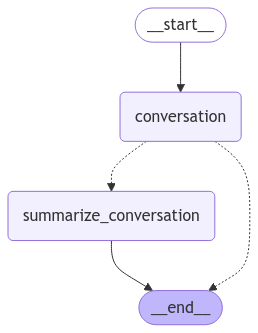

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [10]:
# Configuration for thread
config = {"configurable": {"thread_id": "1"}}

# Start a conversation
input_message = HumanMessage(content="hi! I'm Raheela")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# Check the persisted state
graph_state = graph.get_state(config)
graph_state

Using summary: The conversation began with introductions, where I learned the user's name is Raheela and her hobby is painting. We then discussed abstract painting, providing a description of the art style, its characteristics (non-representational, emphasis on form and composition, emotional expression, open to interpretation), and different types (geometric, lyrical, gestural, color field).  Following this discussion,  the conversation briefly returned to Raheela's personal details, confirming her name and hobby. Finally, a summary of the conversation was requested and provided.

Message count: 6
================================== Ai Message ==================================

Hi Raheela!  It's nice to talk to you again.


StateSnapshot(values={'messages': [HumanMessage(content="What's my name and what is my hobby?", additional_kwargs={}, response_metadata={}, id='fb7b8411-4119-4281-bcdb-3e3370aa1f90'), AIMessage(content='Your name is Raheela, and your hobby is painting.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f69c55fd-be5b-43a2-a891-bef757f936e9-0', usage_metadata={'input_tokens': 580, 'output_tokens': 14, 'total_tokens': 594, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Can you describe about abstract paintings?', additional_kwargs={}, response_metadata={}, id='2b9ace3b-7a38-4e46-ab02-154cb779c5d6'), AIMessage(content='Abstract painting is a genre of art that doesn\'t attempt to represent an accurate depiction of visual reality. Instead, it focuses on expressing ideas and emotions through shapes, colors, forms, and textures.  There\'s no single "look" to abstra

In [11]:
# Configuration for thread
config = {"configurable": {"thread_id": "1"}}

# Start a conversation
input_message = HumanMessage(content="I like painting pictures.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# Check the persisted state
graph_state = graph.get_state(config)
graph_state

Using summary: The conversation began with introductions, where I learned the user's name is Raheela and her hobby is painting. We then discussed abstract painting, providing a description of the art style, its characteristics (non-representational, emphasis on form and composition, emotional expression, open to interpretation), and different types (geometric, lyrical, gestural, color field).  Following this discussion,  the conversation briefly returned to Raheela's personal details, confirming her name and hobby. Finally, a summary of the conversation was requested and provided.

Message count: 8
Messages before summarizing: 8
Existing summary: The conversation began with introductions, where I learned the user's name is Raheela and her hobby is painting. We then discussed abstract painting, providing a description of the art style, its characteristics (non-representational, emphasis on form and composition, emotional expression, open to interpretation), and different types (geometri

StateSnapshot(values={'messages': [HumanMessage(content='I like painting pictures.', additional_kwargs={}, response_metadata={}, id='b5a3679a-2ba0-4cf7-876c-2999c4e1d260'), AIMessage(content="That's wonderful, Raheela!  Painting is a fantastic creative outlet.  What kind of pictures do you enjoy painting?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e8886abf-3cb9-483f-a511-14e36bc99263-0', usage_metadata={'input_tokens': 559, 'output_tokens': 28, 'total_tokens': 587, 'input_token_details': {'cache_read': 0}})], 'summary': "The conversation began with an initial exchange where the AI incorrectly guessed Raheela's name and hobby.  This was corrected, establishing Raheela's identity and confirming her enjoyment of painting as a hobby.  A detailed discussion followed on abstract painting, covering its definition, key characteristics (non-representational nature, focus on fo

In [12]:
# Configuration for thread
config = {"configurable": {"thread_id": "1"}}

# Start a conversation
input_message = HumanMessage(content="What's my name and what is my hobby?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# Check the persisted state
graph_state = graph.get_state(config)
graph_state

Using summary: The conversation began with an initial exchange where the AI incorrectly guessed Raheela's name and hobby.  This was corrected, establishing Raheela's identity and confirming her enjoyment of painting as a hobby.  A detailed discussion followed on abstract painting, covering its definition, key characteristics (non-representational nature, focus on form and composition, emotional expression, and open interpretation), and various styles (geometric, lyrical, gestural, and color field).  After this, the conversation briefly returned to Raheela's personal information, with her explicitly stating her name and interest in painting.  Finally, a summary of the conversation was requested and provided, which is now being extended to include this confirmation of her hobby and the initial incorrect guess.

Message count: 4
================================== Ai Message ==================================

Your name is Raheela, and your hobby is painting.


StateSnapshot(values={'messages': [HumanMessage(content='I like painting pictures.', additional_kwargs={}, response_metadata={}, id='b5a3679a-2ba0-4cf7-876c-2999c4e1d260'), AIMessage(content="That's wonderful, Raheela!  Painting is a fantastic creative outlet.  What kind of pictures do you enjoy painting?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e8886abf-3cb9-483f-a511-14e36bc99263-0', usage_metadata={'input_tokens': 559, 'output_tokens': 28, 'total_tokens': 587, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="What's my name and what is my hobby?", additional_kwargs={}, response_metadata={}, id='6a7338a4-d470-4ef9-a699-f1504d3fca27'), AIMessage(content='Your name is Raheela, and your hobby is painting.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings'

In [13]:
# Configuration for thread
config = {"configurable": {"thread_id": "1"}}

# Start a conversation
input_message = HumanMessage(content="Can you describe about abstract paintings?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

# Check the persisted state
graph_state = graph.get_state(config)
graph_state

Using summary: The conversation began with an initial exchange where the AI incorrectly guessed Raheela's name and hobby.  This was corrected, establishing Raheela's identity and confirming her enjoyment of painting as a hobby.  A detailed discussion followed on abstract painting, covering its definition, key characteristics (non-representational nature, focus on form and composition, emotional expression, and open interpretation), and various styles (geometric, lyrical, gestural, and color field).  After this, the conversation briefly returned to Raheela's personal information, with her explicitly stating her name and interest in painting.  Finally, a summary of the conversation was requested and provided, which is now being extended to include this confirmation of her hobby and the initial incorrect guess.

Message count: 6
================================== Ai Message ==================================

Abstract paintings are works of art that don't attempt to represent an accurate 

StateSnapshot(values={'messages': [HumanMessage(content='I like painting pictures.', additional_kwargs={}, response_metadata={}, id='b5a3679a-2ba0-4cf7-876c-2999c4e1d260'), AIMessage(content="That's wonderful, Raheela!  Painting is a fantastic creative outlet.  What kind of pictures do you enjoy painting?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e8886abf-3cb9-483f-a511-14e36bc99263-0', usage_metadata={'input_tokens': 559, 'output_tokens': 28, 'total_tokens': 587, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="What's my name and what is my hobby?", additional_kwargs={}, response_metadata={}, id='6a7338a4-d470-4ef9-a699-f1504d3fca27'), AIMessage(content='Your name is Raheela, and your hobby is painting.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings'

In [30]:
# Retrieve state using thread ID
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="What's my name and what is my hobby?", additional_kwargs={}, response_metadata={}, id='fb7b8411-4119-4281-bcdb-3e3370aa1f90'), AIMessage(content='Your name is Raheela, and your hobby is painting.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f69c55fd-be5b-43a2-a891-bef757f936e9-0', usage_metadata={'input_tokens': 580, 'output_tokens': 14, 'total_tokens': 594, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='Can you describe about abstract paintings?', additional_kwargs={}, response_metadata={}, id='2b9ace3b-7a38-4e46-ab02-154cb779c5d6'), AIMessage(content='Abstract painting is a genre of art that doesn\'t attempt to represent an accurate depiction of visual reality. Instead, it focuses on expressing ideas and emotions through shapes, colors, forms, and textures.  There\'s no single "look" to abstra

In [14]:
# Retrive chat history : step1 get all messages key (rm note check)
# get all messages
config = {"configurable": {"thread_id": "1"}}
messages = graph.get_state(config).values.get("messages", "")
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='I like painting pictures.', additional_kwargs={}, response_metadata={}, id='b5a3679a-2ba0-4cf7-876c-2999c4e1d260'), AIMessage(content="That's wonderful, Raheela!  Painting is a fantastic creative outlet.  What kind of pictures do you enjoy painting?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e8886abf-3cb9-483f-a511-14e36bc99263-0', usage_metadata={'input_tokens': 559, 'output_tokens': 28, 'total_tokens': 587, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="What's my name and what is my hobby?", additional_kwargs={}, response_metadata={}, id='6a7338a4-d470-4ef9-a699-f1504d3fca27'), AIMessage(content='Your name is Raheela, and your hobby is painting.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings'

In [15]:
# get number of messages
config = {"configurable": {"thread_id": "1"}}
messages = graph.get_state(config).values.get("messages", "")
len(messages)

6

In [16]:
# check stream  step2 do streaming (rm note check)
# Configuration for thread
config = {"configurable": {"thread_id": "1"}}

# Start a conversation
input_message = HumanMessage(content="I like painting pictures.")
output = graph.stream({"messages": [input_message]}, config)
# for m in output['messages'][-1:]:
#     m.pretty_print()

# Check the persisted state
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='I like painting pictures.', additional_kwargs={}, response_metadata={}, id='b5a3679a-2ba0-4cf7-876c-2999c4e1d260'), AIMessage(content="That's wonderful, Raheela!  Painting is a fantastic creative outlet.  What kind of pictures do you enjoy painting?\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-e8886abf-3cb9-483f-a511-14e36bc99263-0', usage_metadata={'input_tokens': 559, 'output_tokens': 28, 'total_tokens': 587, 'input_token_details': {'cache_read': 0}}), HumanMessage(content="What's my name and what is my hobby?", additional_kwargs={}, response_metadata={}, id='6a7338a4-d470-4ef9-a699-f1504d3fca27'), AIMessage(content='Your name is Raheela, and your hobby is painting.\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings'

**Module 2 :**  6.2_chatbot_external_memory_with_postgres.ipynb (Revision)

**Module 3 :** 1_streaming-interruption.ipynb

[Class09:LangGraph:Streaming in LangGraph, LangGraph Studio, How to run LangGraph Studio on Windows - 28 Nov 2024](https://www.youtube.com/watch?v=Vonh9hUgnW4&list=PL0vKVrkG4hWoHDg46N85-9NDhmOaPWEwA&index=10)

`.stream` and `.astream` are sync and async methods for streaming back results.


* `values`: This streams the full state of the graph after each node is called.
* `updates`: This streams updates to the state of the graph after each node is called.

Let's look at `stream_mode="updates"`.

Because we stream with `updates`, we only see updates to the state after node in the graph is run.

Each `chunk` is a dict with `node_name` as the key and the updated state as the value.

In [17]:
pool.close()

### Persisting state

Using database like Postgres means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Postgres DB on disk.
